In [96]:
# imports
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import os
import sys
import time
import matplotlib.pyplot as plt

# import utils from directory above     
sys.path.append("../..")
from data import yahoo


### VARIABLES

In [238]:
##  data slice to search for
START_DATE = '04/01/2023'  
END_DATE = '04/03/2023'
TICKER = 'BTC=F'  ## ticker used [compatiable to data source used]
HISTORIC_PERIOD = 10  ## years to search over
FEATURE = 'Close'  ## feature to fit to
NORM = 1 ##  norm to use
INTERVAL = 60*24  ##  interval in mins

___

### OPTIMISATION

In [239]:
# import data
data = yahoo.Yahoo()
history_start = (datetime.strptime(START_DATE, '%d/%m/%Y') - timedelta(days=(HISTORIC_PERIOD*365))).strftime('%d/%m/%Y')

df = data.get_history(ticker='GC=F', data_interval=INTERVAL, start_date=history_start, end_date=datetime.utcnow().strftime('%d/%m/%Y'))
sample_df = data.get_history(ticker='GC=F', data_interval=60*24, start_date=START_DATE, end_date=END_DATE)

df.index = pd.to_datetime(df.index,utc=True)
df = df[~df.index.duplicated(keep='first')]
try:
    df = df[df.index < datetime.fromisoformat(datetime.utcnow().strftime('%Y-%m-%d')).strftime('%Y-%m-%d %H:%M:%S')+"+00:00"]        
except Exception as e:
    print(e) #ignore

df = df[FEATURE]
sample_df = sample_df[FEATURE]
    

In [240]:
# search optimal fit
window = len(sample_df)
residuals = {}

reference_df = np.array(sample_df / sample_df[0]) - 1

for i in range(0,len(df)-2*len(sample_df)): 
    if NORM == 2: # favours distributed error___### OPTIMISATION
        test_df = np.array(df.iloc[i:i+window] / df.iloc[i]) - 1
        residuals[df.index[i]] = ((test_df - reference_df)**2).sum()
    if NORM == 1: # favours single larger error
        test_df = np.array(df.iloc[i:i+window] / df.iloc[i]) - 1
        residuals[df.index[i]] = (abs(test_df - reference_df)).sum()

# sort residuals
residuals = sorted(residuals.items(), key=lambda item: item[1])

___

### PLOT

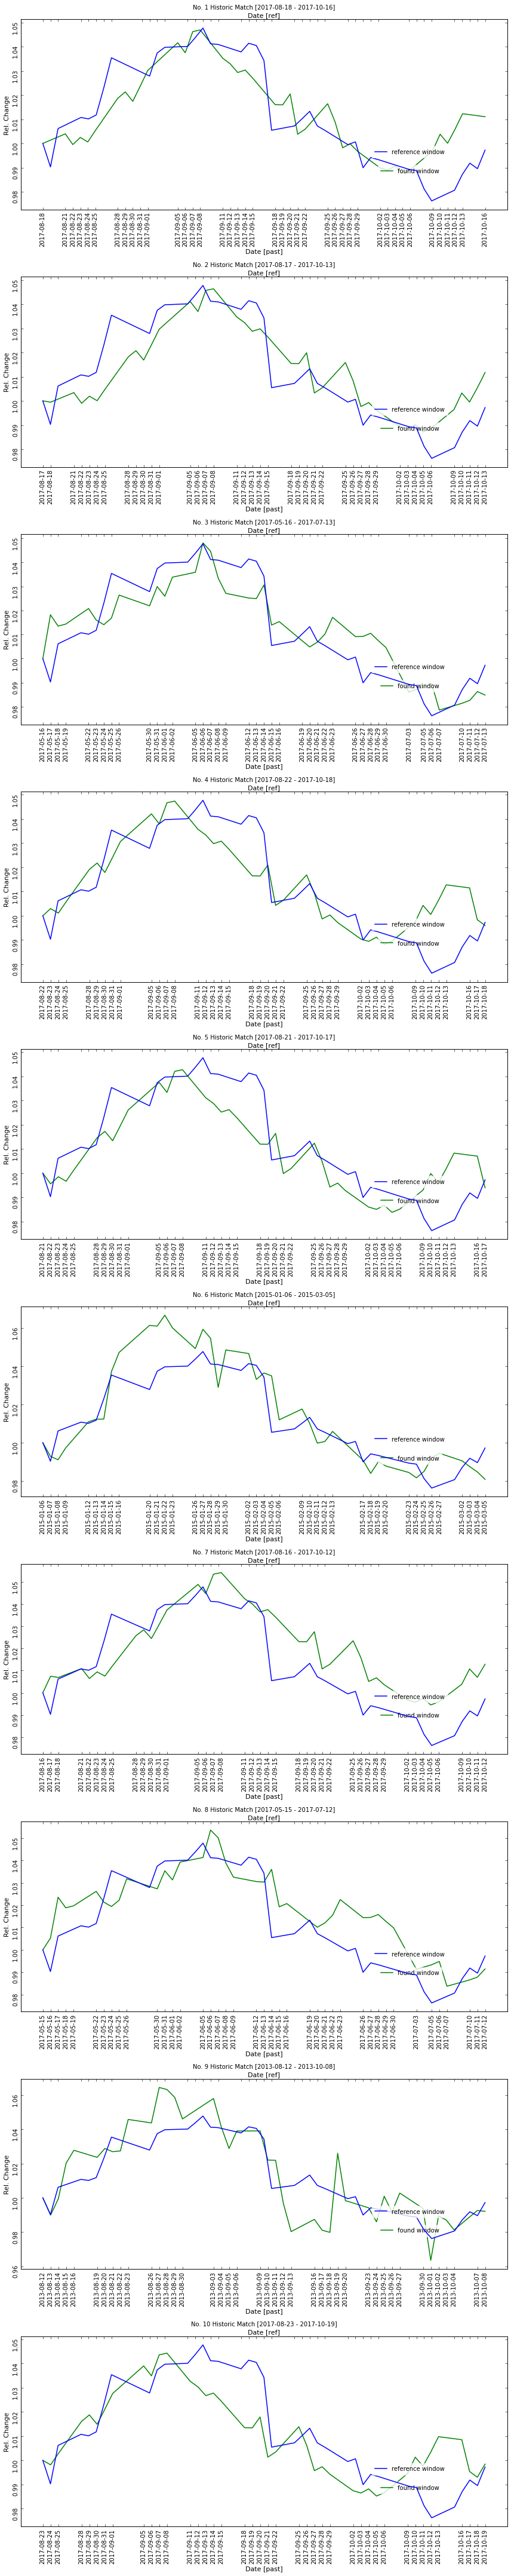

In [241]:
# plotting

#------------------------------------#
SHOW = 10# number of plots to show
#------------------------------------#

from matplotlib import rc
rc('text', usetex=False)

plt.rc('font', size=10)          # controls default text sizes
plt.rc('axes', titlesize=10)     # fontsize of the axes title
plt.rc('axes', labelsize=11)     # fontsize of the x and y labels
plt.rc('xtick', labelsize=10)    # fontsize of the tick labels
plt.rc('ytick', labelsize=10)    # fontsize of the tick labels
plt.rc('legend', fontsize=10)    # legend fontsize

fig, axs = plt.subplots(SHOW, 1, figsize=(12, 6*SHOW))

for i in range(SHOW):
    
    result = df.loc[residuals[i][0]::].head(window) / df.loc[residuals[i][0]]
    reference = sample_df.copy() / sample_df.iloc[0]
    
    resi = residuals[i][1]
    date = residuals[i][0]
    
    ##  found data
    ax1 = axs[i]
    ax1.plot(result, label='found window', linewidth=1.5, color='green')
    ax1.set_xlabel('Date [past]')
    ax1.set_ylabel('Rel. Change')

    ax1.set_xticks(result.index)
    ax1.tick_params(direction="in", length=4, width=0.6)
    ax1.tick_params(right=True, top=True, labelright=False, labeltop=False,rotation=90)
    
    ##  reference data
    ax2 = ax1.twiny()
    ax2.plot(reference, label='reference window', linewidth=1.5, color='blue')
    
    ax2.set_xlabel('Date [ref]')
    
    ax2.set_xticks(reference.index)
    ax2.set_xticklabels(reference.index)
    ax2.tick_params(direction="in", length=4, width=0.6)
    ax2.tick_params(right=True, top=True, labelright=False, labeltop=False,rotation=90)

    ##  legends
    leg = ax1.legend(loc='upper center', bbox_to_anchor=(.8, 0.25),
              fancybox=False, shadow=False, ncol=3, edgecolor='w', borderpad=0.5)
    leg.get_frame().set_linewidth(0.5)
    
    leg = ax2.legend(loc='upper center', bbox_to_anchor=(.8, 0.35),
              fancybox=False, shadow=False, ncol=3, edgecolor='w', borderpad=0.5)
    leg.get_frame().set_linewidth(0.5)
    
    title = ax1.set_title('No. '+str(i+1)+" Historic Match ["+str(result.index[0])[0:10]+' - '+str(result.index[-1])[0:10]+']')

fig.tight_layout()
plt.show()

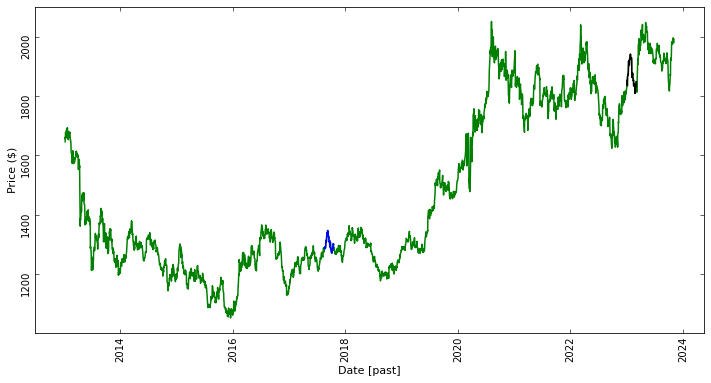

In [243]:
# plotting with bigger picture

#------------------------------------#
OPTION = 1  # which solution to view
#------------------------------------#

fig, axs = plt.subplots(1, 1, figsize=(12, 6))

##  all data
axs.plot(df, label='All Data', linewidth=1.5, color='green')
axs.set_xlabel('Date [past]')
axs.set_ylabel('Price ($)')

##  highlight interest areas
axs.plot(sample_df, label='All Data', linewidth=1.5, color='black')
axs.plot(df.loc[residuals[OPTION-1][0]::].head(window), linewidth=1.5, color='blue')

axs.tick_params(direction="in", length=4, width=0.6)
axs.tick_params(right=True, top=True, labelright=False, labeltop=False,rotation=90)